# Predicting Cryptocurrency Price Movement with LSTM
This work is inspired by [this blog post by David Sheehan](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/).

In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from Coinmarketcap.coinmarketcap import CoinMarketcap


# Instantiate CoinMarketcap class
cmk = CoinMarketcap()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Retreive Data For Analysis

In [56]:
# get market info for bitcoin from the start of 2013 to the current day
bitcoin_market_info = cmk.get_price_history(coin_name='bitcoin', start='20130101', end=None)

# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
0,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,0.046588,92,4,1.034908
1,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,0.076264,91,4,0.977320
2,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000,0.049957,90,3,1.011759
3,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000,0.082651,89,3,0.960827
4,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000,0.114418,88,3,0.898062


In [57]:
# get market info for ethereum from the start of 2013 to the current day
ethereum_market_info = cmk.get_price_history(coin_name='ethereum', start='20130101', end=None)

# look at the first few rows
ethereum_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
0,2018-04-02,379.70,395.17,377.59,386.43,1102260000,37422500000,0.046300,92,4,1.017725
1,2018-04-01,397.25,400.53,363.81,379.61,1256930000,39144700000,0.092435,91,4,0.955595
2,2018-03-31,395.00,418.47,392.95,396.46,1323920000,38914900000,0.064608,90,3,1.003696
3,2018-03-30,385.90,409.93,368.63,394.64,1878130000,38010600000,0.107023,89,3,1.022648
4,2018-03-29,448.07,450.81,385.81,385.97,1970230000,44125000000,0.145067,88,3,0.861406


## Plot Test Train Split

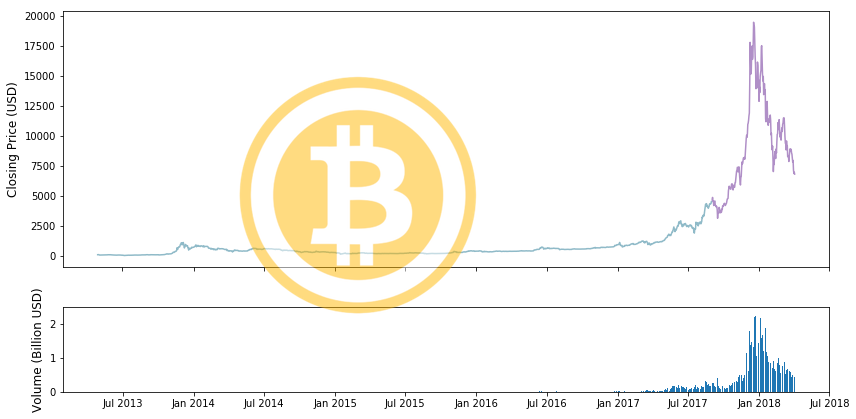

,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
0,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,0.046588,92,4,1.034908
1,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,0.076264,91,4,0.977320
2,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000,0.049957,90,3,1.011759
3,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000,0.082651,89,3,0.960827
4,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000,0.114418,88,3,0.898062


In [58]:
split_date = '2017-09-01'
cmk.plot_price(
    market_info=bitcoin_market_info, 
    split_date=split_date,
    image_url="http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png"
)
bitcoin_market_info.head()

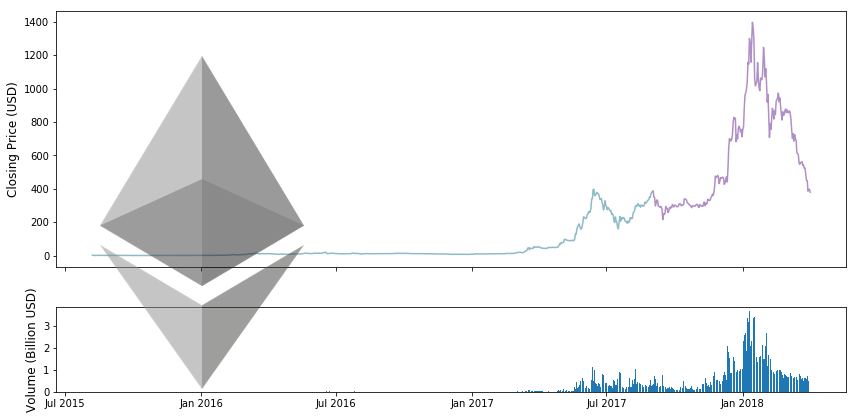

In [59]:
cmk.plot_price(
    market_info=ethereum_market_info, 
    split_date=split_date,
    image_url="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png"
)

## Inspecting Price Change Distribution

In [60]:
# Split Data into Train and Test
bitcoin_train, bitcoin_test = (bitcoin_market_info[bitcoin_market_info['Date']< split_date], bitcoin_market_info[bitcoin_market_info['Date'] >= split_date])
ethereum_train, ethereum_test = (ethereum_market_info[ethereum_market_info['Date']< split_date], ethereum_market_info[ethereum_market_info['Date'] >= split_date])
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
0,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,0.046588,92,4,1.034908
1,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,0.076264,91,4,0.977320
2,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000,0.049957,90,3,1.011759
3,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000,0.082651,89,3,0.960827
4,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000,0.114418,88,3,0.898062


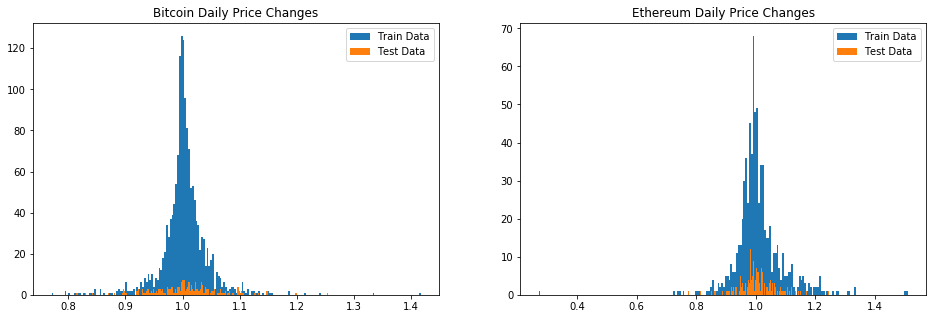

Bitcoin Distributions: 
Train  mu, sigma: 0.30%, 0.04%
Test  mu, sigma: 0.36%, 0.06%
Total  mu, sigma: 0.31%, 0.05%
Ethereum Distribution: 
Train mu, sigma: 0.97%, 0.08%
Test mu, sigma: 0.16%, 0.06%
Total mu, sigma: 0.79%, 0.08%


In [61]:
# Create Axis
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

# Plot Train and Test Data for Bitcoin and Ethereum
ax1.hist(bitcoin_train['day_diff'].values, bins=200, label='Train Data')
ax1.hist(bitcoin_test['day_diff'].values, bins=200, label='Test Data')
ax2.hist(ethereum_train['day_diff'].values, bins=200, label='Train Data')
ax2.hist(ethereum_test['day_diff'].values, bins=200, label='Test Data')

# Add Legend
ax1.legend(frameon=True)
ax2.legend(frameon=True)

# Titles
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

# Print Distribution Information
print("Bitcoin Distributions: ")
print("Train  mu, sigma: {0:.2f}%, {1:.2f}%".format(100*bitcoin_train['day_diff'].mean()-100, bitcoin_train['day_diff'].std()))
print("Test  mu, sigma: {0:.2f}%, {1:.2f}%".format(100*bitcoin_test['day_diff'].mean()-100, bitcoin_test['day_diff'].std()))
print("Total  mu, sigma: {0:.2f}%, {1:.2f}%".format(100*bitcoin_market_info['day_diff'].mean()-100, bitcoin_market_info['day_diff'].std()))

print("Ethereum Distribution: ")
print("Train mu, sigma: {0:.2f}%, {1:.2f}%".format(100*ethereum_train['day_diff'].mean()-100, ethereum_train['day_diff'].std()))
print("Test mu, sigma: {0:.2f}%, {1:.2f}%".format(100*ethereum_test['day_diff'].mean()-100, ethereum_test['day_diff'].std()))
print("Total mu, sigma: {0:.2f}%, {1:.2f}%".format(100*ethereum_market_info['day_diff'].mean()-100, ethereum_market_info['day_diff'].std()))

From the above we can see that on average Bitcoin increases in price 0.31% per day, and Ethereum 0.81% per day. If we were to take these as ground truth means, we can extrapolate to the future. Let's take 10 years of extrapolated price growth:

In [62]:
bitcoin_today = bitcoin_market_info['Close'].values[0]
ethereum_today = ethereum_market_info['Close'].values[0]

bitcoin_mu = bitcoin_market_info['day_diff'].mean()
ethereum_mu = ethereum_market_info['day_diff'].mean()

bitcoin_in_10_years = bitcoin_today*(bitcoin_mu)**(365*10)
ethereum_in_10_years = ethereum_today*(ethereum_mu)**(365*10)

print("Bitcoin Value Today USD: ", bitcoin_today)
print("Bitcoin Value in 10 Years USD: ", bitcoin_in_10_years)
print("Ethereum Value Today USD: ", ethereum_today)
print("Ethereum Value in 10 Years USD: ", ethereum_in_10_years)
bitcoin_market_info.head()

Bitcoin Value Today USD:  7083.8
Bitcoin Value in 10 Years USD:  481003721.8703405
Ethereum Value Today USD:  386.43
Ethereum Value in 10 Years USD:  1318427780818812.5


,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
0,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,0.046588,92,4,1.034908
1,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,0.076264,91,4,0.977320
2,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000,0.049957,90,3,1.011759
3,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000,0.082651,89,3,0.960827
4,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000,0.114418,88,3,0.898062


## Format Data into Training and Test input for Deep Learning

In [63]:
# need to reverse the data frame so that subsequent rows represent later timepoints
bitcoin_market_info = bitcoin_market_info.sort_values(by='Date')
# Set 0 Volumes to 1 to avoid division by zero
bitcoin_market_info['Volume'][bitcoin_market_info['Volume'] == 0] = 1
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
1800,2013-04-28,135.30,135.98,132.10,134.21,1,1500520000,0.028677,118,4,0.991944
1799,2013-04-29,134.44,147.49,134.00,144.54,1,1491160000,0.100342,119,4,1.075126
1798,2013-04-30,144.00,146.93,134.05,139.00,1,1597780000,0.089444,120,4,0.965278
1797,2013-05-01,139.00,139.89,107.72,116.99,1,1542820000,0.231439,121,5,0.841655
1796,2013-05-02,116.38,125.60,92.28,105.21,1,1292190000,0.286303,122,5,0.904021


In [64]:
# Split Data into Train / Test
# we don't need the date columns anymore
training_set, test_set = bitcoin_market_info[bitcoin_market_info['Date']<split_date], bitcoin_market_info[bitcoin_market_info['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)
training_set.head()

,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
1800,135.30,135.98,132.10,134.21,1,1500520000,0.028677,118,4,0.991944
1799,134.44,147.49,134.00,144.54,1,1491160000,0.100342,119,4,1.075126
1798,144.00,146.93,134.05,139.00,1,1597780000,0.089444,120,4,0.965278
1797,139.00,139.89,107.72,116.99,1,1542820000,0.231439,121,5,0.841655
1796,116.38,125.60,92.28,105.21,1,1292190000,0.286303,122,5,0.904021


In [65]:
window_len = 10
norm_cols = ['Open', 'High', 'Low', 'Close','Volume']

In [66]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        # Normalize column relative to the latest day of input. Center about 1 instead of 0
        if col == 'Volume':
            temp_set.loc[:, col] = temp_set[col]/temp_set['Volume'].iloc[-1] #-1
        else:
            temp_set.loc[:, col] = temp_set[col]/temp_set['Close'].iloc[-1] #-1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)

In [67]:
LSTM_training_inputs[0]

,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
1800,1.213453,1.219552,1.184753,1.203677,1.0,1500520000,0.028677,118,4,0.991944
1799,1.205740,1.322780,1.201794,1.296323,1.0,1491160000,0.100342,119,4,1.075126
1798,1.291480,1.317758,1.202242,1.246637,1.0,1597780000,0.089444,120,4,0.965278
1797,1.246637,1.254619,0.966099,1.049238,1.0,1542820000,0.231439,121,5,0.841655
1796,1.043767,1.126457,0.827623,0.943587,1.0,1292190000,0.286303,122,5,0.904021
1795,0.952915,0.969776,0.709417,0.876682,1.0,1180070000,0.273224,123,5,0.920000
1794,0.879821,1.031390,0.829596,1.008969,1.0,1089890000,0.229358,124,5,1.146789
1793,1.012556,1.065471,0.960897,1.039552,1.0,1254760000,0.103277,125,5,1.026661
1792,1.040179,1.118027,0.956413,1.007175,1.0,1289470000,0.155372,126,5,0.968270
1791,1.006726,1.017399,0.876233,1.000000,1.0,1248470000,0.140223,127,5,0.993318


In [68]:
LSTM_training_outputs[0]

0.8462111616123984

In [69]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        # Normalize column relative to the latest day of input. Center about 1 instead of 0
        if col == 'Volume':
            temp_set.loc[:, col] = temp_set[col]/temp_set['Volume'].iloc[-1] #-1
        else:
            temp_set.loc[:, col] = temp_set[col]/temp_set['Close'].iloc[-1] #-1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)

In [70]:
LSTM_test_inputs[0]

,Open,High,Low,Close,Volume,Market Cap,Volatility,doy,month,day_diff
213,1.140390,1.186534,1.134756,1.186534,1.547910,77748400000,0.045404,244,9,1.040464
212,1.188817,1.206673,1.083993,1.110559,1.621200,81060600000,0.103195,245,9,0.934172
211,1.112136,1.143378,1.071466,1.111576,1.151332,75841700000,0.064661,246,9,0.999496
210,1.113679,1.113679,0.996473,1.027497,1.779136,75955500000,0.105241,247,9,0.922616
209,1.025552,1.073952,0.969723,1.061507,1.606805,69954400000,0.101632,248,9,1.035059
208,1.061522,1.119893,1.061522,1.115010,1.293617,72418700000,0.054988,249,9,1.050389
207,1.113075,1.129058,1.089351,1.115680,1.098583,75945000000,0.035673,250,9,1.002340
206,1.116960,1.130504,0.988416,1.025664,1.608544,76220200000,0.127209,251,9,0.918263
205,1.025921,1.045084,0.997858,1.025011,0.825584,70017200000,0.046033,252,9,0.999113
204,1.025807,1.029712,0.958306,1.000000,1.000000,70018100000,0.069609,253,9,0.974842


In [71]:
LSTM_test_outputs[0]

0.8506258163822233

## LSTM Price Prediction

In [72]:
# Convert inputs to numpy arrays
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [73]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [74]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
history = model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 15s - loss: 0.4035
Epoch 2/50
 - 15s - loss: 0.2072
Epoch 3/50
 - 15s - loss: 0.1435
Epoch 4/50
 - 15s - loss: 0.1111
Epoch 5/50
 - 16s - loss: 0.1032
Epoch 6/50
 - 16s - loss: 0.1024
Epoch 7/50
 - 16s - loss: 0.1015
Epoch 8/50
 - 16s - loss: 0.1017
Epoch 9/50
 - 15s - loss: 0.1018
Epoch 10/50
 - 16s - loss: 0.1017
Epoch 11/50
 - 16s - loss: 0.1016
Epoch 12/50
 - 16s - loss: 0.1017
Epoch 13/50
 - 16s - loss: 0.1016
Epoch 14/50
 - 16s - loss: 0.1018
Epoch 15/50
 - 16s - loss: 0.1019
Epoch 16/50
 - 16s - loss: 0.1013
Epoch 17/50
 - 16s - loss: 0.1013
Epoch 18/50
 - 16s - loss: 0.1015
Epoch 19/50
 - 19s - loss: 0.1018
Epoch 20/50
 - 15s - loss: 0.1015
Epoch 21/50
 - 16s - loss: 0.1019
Epoch 22/50
 - 15s - loss: 0.1020
Epoch 23/50
 - 16s - loss: 0.1015
Epoch 24/50
 - 15s - loss: 0.1014
Epoch 25/50
 - 15s - loss: 0.1015
Epoch 26/50
 - 15s - loss: 0.1017
Epoch 27/50
 - 15s - loss: 0.1012
Epoch 28/50
 - 15s - loss: 0.1014
Epoch 29/50
 - 15s - loss: 0.1015
Epoch 30/50
 - 15s - lo

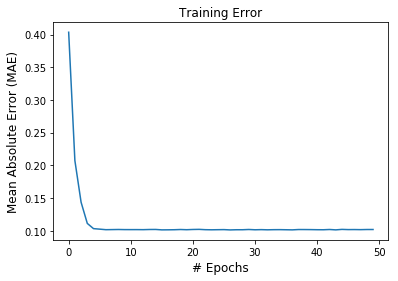

In [75]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(history.epoch, history.history['loss'])
ax1.set_title('Training Error')

if model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

### Train Set Performance

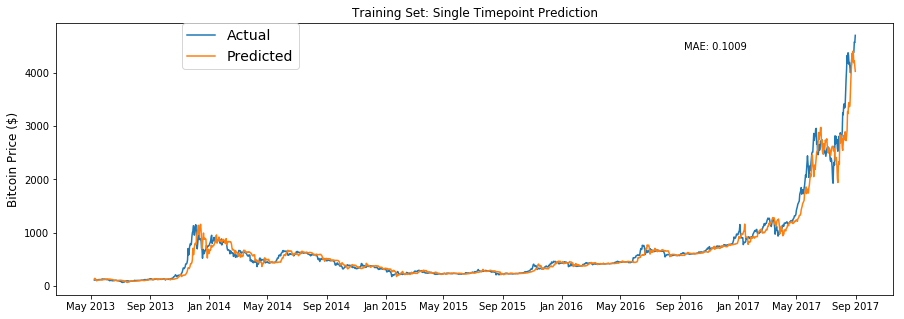

In [96]:
# This code is from: https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(bitcoin_market_info[bitcoin_market_info['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['Close'][window_len:], label='Actual')
ax1.plot(bitcoin_market_info[bitcoin_market_info['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(model.predict(LSTM_training_inputs))) * training_set['Close'].values[:-window_len])[-1], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(model.predict(LSTM_training_inputs)))-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
plt.show()

### Test Set Performance

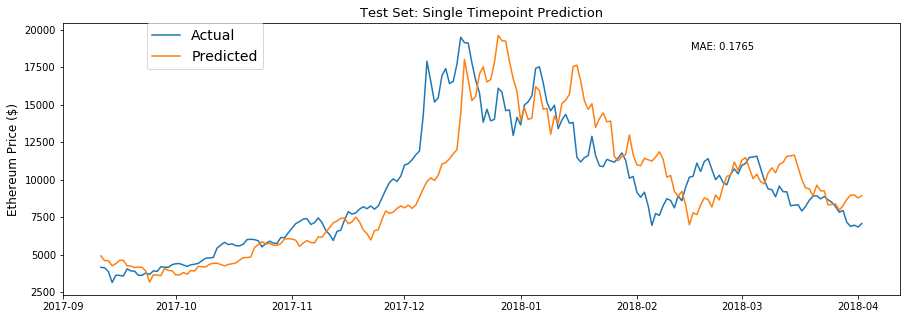

In [95]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(bitcoin_market_info[bitcoin_market_info['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['Close'][window_len:], label='Actual')
ax1.plot(bitcoin_market_info[bitcoin_market_info['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(model.predict(LSTM_test_inputs))) * test_set['Close'].values[:-window_len])[-1], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(model.predict(LSTM_test_inputs)))-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()